In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Path to the dataset in Google Drive
dataset_path = "/content/drive/MyDrive/pcam_data"

# Example: List files to confirm
import os
print(os.listdir(dataset_path))

# Use with PyTorch (adjust paths to specific files)
train_image_file = os.path.join(dataset_path, "pcam/training_split.h5")
train_label_file = os.path.join(dataset_path, "Labels/Labels/camelyonpatch_level_2_split_train_y.h5")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['Metadata', 'Labels', 'camelyonpatch_level_2_split_train_mask', 'pcam']


Number of training samples: 262144


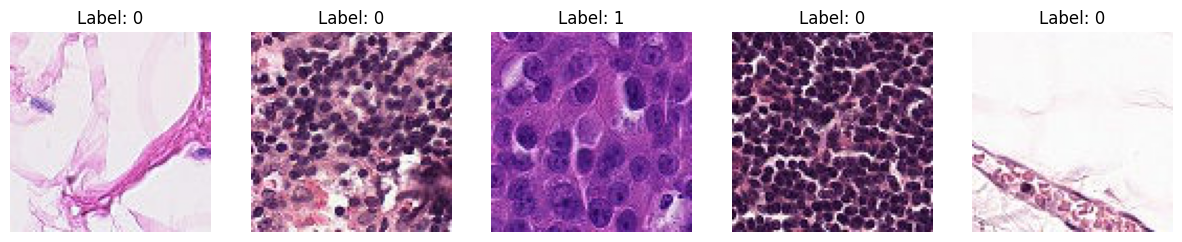

In [ ]:
from google.colab import drive
import h5py
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Step 2: Define the Dataset class with on-the-fly loading
class PatchCamelyonDataset(Dataset):
    def __init__(self, image_file, label_file, transform=None):
        self.image_file = image_file
        self.label_file = label_file
        self.transform = transform
        # Get the number of samples without loading the full dataset
        with h5py.File(image_file, 'r') as f:
            self.num_samples = len(f['x'])

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        # Load only the specific image and label at the given index
        with h5py.File(self.image_file, 'r') as f:
            image = np.array(f['x'][idx])  # Shape: (96, 96, 3)
        with h5py.File(self.label_file, 'r') as f:
            label = np.array(f['y'][idx]).squeeze()  # Scalar (0 or 1)

        # Convert to PyTorch tensor and adjust dimensions
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # (3, 96, 96)
        label = torch.tensor(label, dtype=torch.float32)

        # Apply transformations if provided
        if self.transform:
            image = self.transform(image / 255.0)  # Normalize to [0, 1]
        else:
            image = image / 255.0  # Default normalization

        return image, label

# Define transformations
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
])

# Create dataset and dataloader
train_dataset = PatchCamelyonDataset(train_image_file, train_label_file, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
print(f"Number of training samples: {len(train_dataset)}")

# Step 3: Visualize examples
def visualize_examples(loader, num_examples=5):
    images, labels = next(iter(loader))
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))
    for i in range(num_examples):
        img = images[i].permute(1, 2, 0).numpy()  # Convert (3, 96, 96) to (96, 96, 3)
        label = labels[i].item()
        axes[i].imshow(img)
        axes[i].set_title(f"Label: {int(label)}")
        axes[i].axis('off')
    plt.show()

# Visualize 5 examples from the training set
visualize_examples(train_loader, num_examples=5)